<a href="https://colab.research.google.com/github/archqua/pipeline_training/blob/master/mnist_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
parameters = dict(
    pretrain_epochs = 1,
    train_epochs = 1,
    base = 2,
    patience = 1,
    batch = 128,
    metrics = ["accuracy",],
    drift = "flip",
    alg = "greedy",
    seed  = 12309,
    logp = "mnist_artifacts",
)
for p in parameters:
    if p not in locals():
        v = parameters[p]
        if isinstance(v, str):
            exec(f"{p} = '{v}'")
        else:
            exec(f"{p} = {v}")


In [2]:
from datetime import datetime
import json
import os
from pprint import pp as ppr

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.random.set_seed(seed)
logpath = os.path.join(
    logp,
    f"pe{pretrain_epochs}_te{train_epochs}_b{base}_p{patience}_{drift}_{alg}",
)
os.makedirs(logpath, exist_ok=True)
logjs = {
    "started": datetime.now().isoformat(),
    "parameters": parameters.copy(),
}
ppr(logjs)


{'started': '2024-10-12T12:49:59.007138',
 'parameters': {'pretrain_epochs': 1,
                'train_epochs': 1,
                'base': 2,
                'patience': 1,
                'batch': 128,
                'metrics': ['accuracy'],
                'drift': 'flip',
                'alg': 'greedy',
                'seed': 12309,
                'logp': 'mnist_artifacts'}}


In [3]:
def printeval(evvals, evkeys=["loss"] + metrics):
    for k, v in zip(evkeys, evvals):
        print(f"{k}:\t{v:.4f}")

def flipaug(img, lbl):
    return tf.image.random_flip_left_right(img), lbl


def drifted(dataset, seed=seed, drift=drift):
    drift = drift.lower()
    if drift == "flip":
        return dataset.map(flipaug)
    else:
        raise ValueError(f"Drift {drift} is unknown")


In [4]:
mnist = datasets.mnist

Xy_train, Xy_val = mnist.load_data()
def mapimg(img, label):
    return tf.image.convert_image_dtype(img, dtype=tf.float32), label

train_ref = (
    tf.data.Dataset.from_tensor_slices(Xy_train)
    .shuffle(Xy_train[0].shape[0])
    .batch(batch)
    .map(mapimg)
)
val_ref = (
    tf.data.Dataset.from_tensor_slices(Xy_val)
    .shuffle(Xy_val[0].shape[0])
    .batch(batch)
    .map(mapimg)
)
train_drifted = drifted(train_ref)
val_drifted = drifted(val_ref)


In [5]:
def greedy_loss_fn(
    model,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    patience=None,
    factoring_layer="factor",
):
    factoring_layer = model.get_layer(factoring_layer)
    def wrapped(trg, logits):
        inferred_lbls, miss_mask, diff_mask = factoring_layer.greedy_lblprop(
            tf.stop_gradient(logits), trg, patience=patience,
        )
        match_mask = ~miss_mask
        return loss(
            tf.boolean_mask(inferred_lbls, match_mask),
            tf.boolean_mask(logits, match_mask),
        )
    return wrapped

class Factor(layers.Layer):
    def __init__(self, base=base, patience=patience, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.base = tf.constant(base, dtype=tf.int32, shape=())
        self.patience = patience

    def call(self, logits):
        return self.factor(tf.argmax(logits, axis=-1))

    def factor(self, labels):
        return tf.cast(tf.keras.ops.mod(labels, self.base), tf.int32)

    def refactor(self, logits, miss_mask, ninf=-1.0e+06):
        am = tf.argmax(logits, axis=-1, output_type=tf.int32)
        mask = am[:, tf.newaxis] == tf.range(logits.shape[-1], dtype=tf.int32)[tf.newaxis, :]
        mask &= miss_mask[:, tf.newaxis]
        logits = tf.where(mask, ninf, logits)
        return self(logits), logits

    def greedy_lblprop(self, logits, trg, patience=None):
        # this line is entirely to satisfy tf static checker
        trg = tf.cast(trg, tf.int32)
        if patience is None:
            patience = self.patience
        assert patience >= 0, f"for greedy label propagation specify patience >= 0, not {patience}"
        guess = self(logits)
        first_miss_mask = guess != trg
        miss_mask = first_miss_mask
        # this implementation is suboptimal
        # because it recomputes good values
        for d in range(patience):
            guess, logits = self.refactor(logits, miss_mask)
            miss_mask = guess != trg
        diff_mask = first_miss_mask ^ miss_mask
        # we could smooth over miss_mask, not simply argmax
        return tf.argmax(logits, axis=-1, output_type=tf.int32), miss_mask, diff_mask

# input
inp = tf.keras.Input((28, 28, 1), name="img")
# cnn
cnn = tf.keras.Sequential([
    layers.InputLayer((28, 28, 1), name="inp"),
    layers.Conv2D(2, (5, 5), activation='relu', name="conv1"),  # 24x24x2
    layers.MaxPooling2D((2, 2), name="pool1"),  # 12x12x2
    layers.Conv2D(4, (5, 5), activation='relu', name="conv2"),  # 8x8x4
    layers.MaxPooling2D((2, 2), name="pool2"),  # 4x4x4
    layers.Conv2D(10, (4, 4), activation='relu', name="conv3"),  # 1x1x10
    layers.Flatten(name="flatten"),
    layers.Dense(10, name="logit"),
], name="logit")
# outputs
logit = cnn(inp)
factor = Factor(base=base, name="factor")(logit)

pp = tf.keras.Model(inp, [factor, logit], name="Pipeline")
pp.summary()



Model: "Pipeline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)                     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logit (Sequential)                   │ (None, 10)                  │           1,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ factor (Factor)                      │ (None)                      │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,016 (3.97 KB)

 Trainable params: 1,016 (3.97 KB)

 Non-trainable params: 0 (0.00 B)

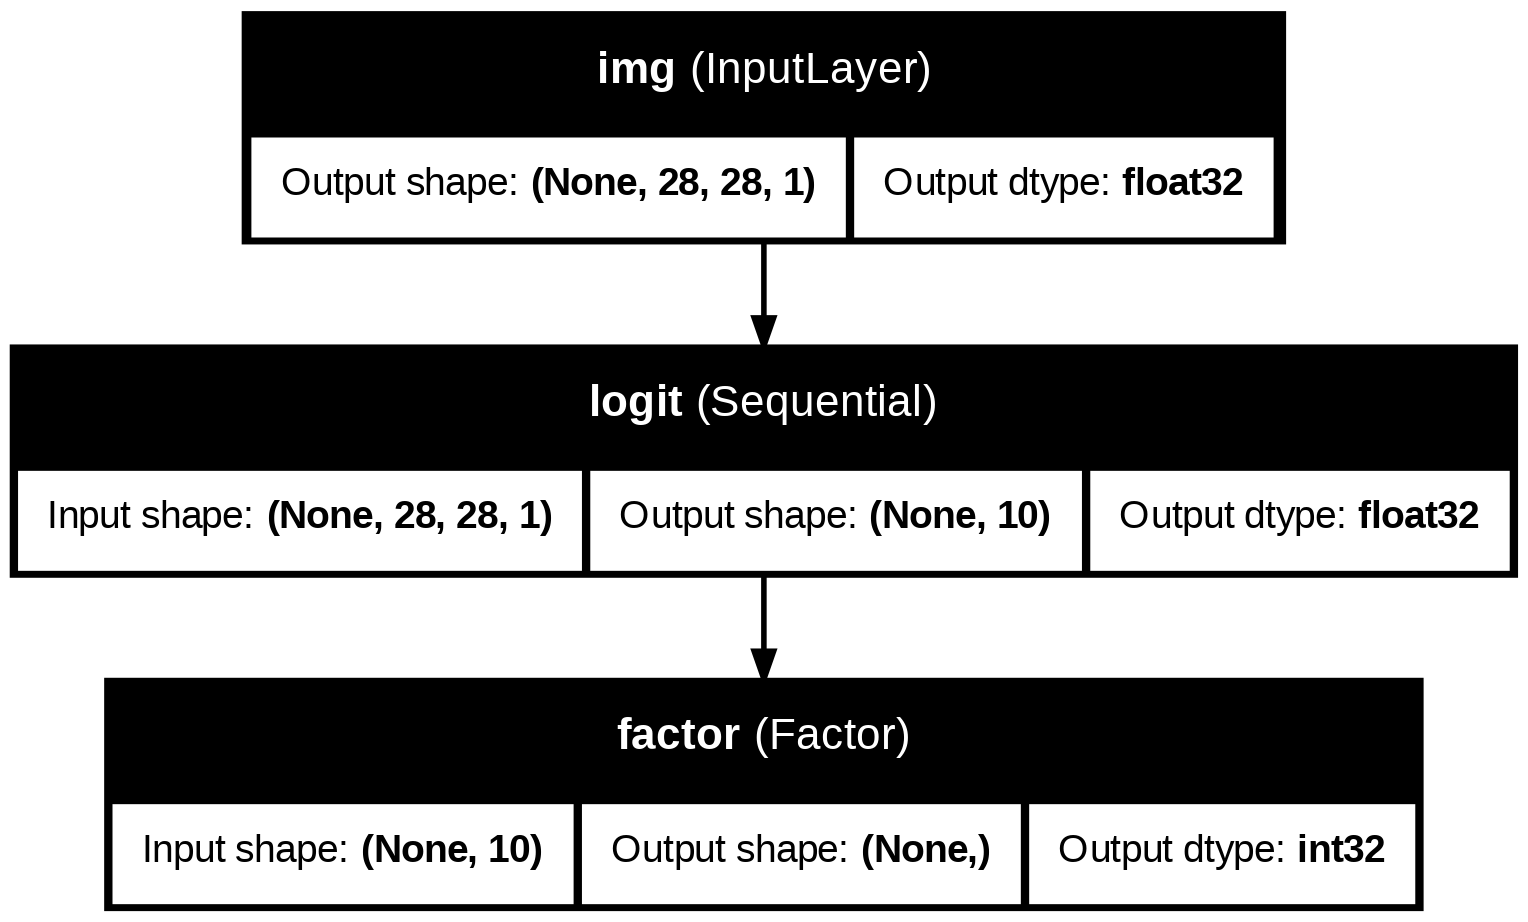

In [6]:
tf.keras.utils.plot_model(
    pp, show_layer_names=True, show_shapes=True, show_dtype=True,
    to_file=os.path.join(logpath, "pipeline.png"),
)

In [7]:
def factor_labels(model, factoring_layer="factor", duplicate=True):
    factoring_layer = model.get_layer(factoring_layer)
    # @tf.function
    def wrapped(img, lbl):
        if duplicate:
            return img, factoring_layer.factor(lbl), lbl
        return img, factoring_layer.factor(lbl)
    return wrapped

train_ref_factored = train_ref.map(factor_labels(pp))
val_ref_factored = val_ref.map(factor_labels(pp))
train_drifted_factored = train_drifted.map(factor_labels(pp))
val_drifted_factored = val_drifted.map(factor_labels(pp))


In [8]:
from types import NoneType
import ipywidgets as widgets
from IPython.display import display
import time


class BatchMeanMetricWrapper(tf.keras.Metric):
    def __init__(self, fn, normalize=100, name=None, dtype=None, **kwargs):
        super().__init__(name=name, dtype=dtype)
        self._fn = fn
        self._kwargs = kwargs
        self._normalize = normalize
        self._counter = 0
        self._data = None
        if dtype is None:
            dtype = tf.float32
        self._dtype = dtype

    def reset_state(self, *args, **kwargs):
        self._counter = 0
        self._data = None

    def update_state(self, y_true, y_pred, *args, **kwargs):
        batchsize = y_true.shape[0]
        upd = tf.cast(self._fn(y_true, y_pred, **self._kwargs), self._dtype)
        if self._normalize is not None:
            upd *= float(self._normalize) / batchsize
        self._counter += batchsize
        if self._data is None:
            self._data = upd
        else:
            self._data *= (self._counter - batchsize) / self._counter
            self._data += batchsize * upd / self._counter

    def result(self, *args, **kwargs):
        return self._data


def pretty_iterator(to_wrap=None, n=None, track_time=True, desc="", width="67%", desc_width="23%"):
    if to_wrap is None:
        if n is None:
            n = 1
        to_wrap = range(n)
    if n is None:
        try:
            n = len(to_wrap)
        except:
            pass

    if track_time:
        start_time = time.time()
        passed = 0.0
    def sdesc(j):
        res = " ".join([desc, f"{j}/{n}"])
        if track_time:
            passed = time.time() - start_time
            res = ", ".join([res, f"{passed:.1f}s passed"])
        return res
    progress = widgets.IntProgress(
        value=0, min=0, max=n,
        description=sdesc(0),
        layout={"width": width},
        style={"description_width": desc_width if len(desc) > 0 or track_time else "0px"},
    )
    display(progress)
    for i, item in enumerate(to_wrap):
        yield item
        passed = time.time() - start_time
        progress.value += 1
        progress.description = sdesc(i+1)


def epochs_iterator(n_epochs=1):
    return pretty_iterator(n=n_epochs, desc="Epoch")

def data_iterator(dataset):
    return pretty_iterator(dataset, desc="Batch")

def cheet_train_step(
    pipeline, data, optimizer, loss, Metrics={"logit": [], "factor": []},
):
    img, trg, lbl = data
    with tf.GradientTape() as tape:
        factors, logits = pipeline(img, training=True)
        loss_value = loss(lbl, logits)
        for M in Metrics["logit"]:
            M.update_state(lbl, tf.argmax(logits, axis=-1))
        for M in Metrics["factor"]:
            M.update_state(trg, factors)
    grads = tape.gradient(loss_value, pipeline.trainable_weights)
    optimizer.apply_gradients(zip(grads, pipeline.trainable_weights))


def greedy_train_step(
    pipeline, data, optimizer, loss, Metrics={"logit": [], "factor": []},
):
    img, trg, lbl = data
    with tf.GradientTape() as tape:
        factors, logits = pipeline(img, training=True)
        loss_value = greedy_loss_fn(pipeline, loss)(trg, logits)
        for M in Metrics["logit"]:
            M.update_state(lbl, tf.argmax(logits, axis=-1))
        for M in Metrics["factor"]:
            M.update_state(trg, factors)
    grads = tape.gradient(loss_value, pipeline.trainable_weights)
    optimizer.apply_gradients(zip(grads, pipeline.trainable_weights))

_train_steps = {
    "cheet": cheet_train_step,
    "greedy": greedy_train_step,
}

def get_train_step(step):
    return _train_steps[step.lower()]

def pipeline_train_loop(
    pipeline,
    train_dataset,
    optimizer,
    step = "greedy",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics,
    epochs=1,
    val_dataset=None,
    pretty=True,
):
    train_step = get_train_step(step)
    if val_dataset is not None:
        val_metrics = []
    train_metrics = []
    Metrics = {"logit": [], "factor": []}
    for m in metrics:
        for k in Metrics:
            Metrics[k].append(tf.keras.metrics.get(m.capitalize()))
    def smetrics() -> str:
        res = ""
        for k in Metrics:
            for M in Metrics[k]:
                Mresult = M.result()
                if Mresult is not None and len(Mresult.shape) < 2:
                    res += f"\t{k}_{M.name}: {Mresult:.4f};"
        return res
    eit = epochs_iterator(epochs) if pretty else range(epochs)
    for e in eit:
        for k in Metrics:
            for M in Metrics[k]:
                M.reset_state()
        tdit = data_iterator(train_dataset) if pretty else train_dataset
        metrics_html = widgets.HTMLMath(
            value = smetrics(),
            placeholder="HTMLM",
            description=f"Epoch {e+1}/{epochs} train --",
            style = {"description_width": "23%"},
            layout={"width": "67%"},
        )
        display(metrics_html)
        for data in tdit:
            train_step(pipeline, data, optimizer, loss, Metrics)
            metrics_html.value = smetrics()
        train_metrics.append({
            k: {
                M.name: M.result() for M in Metrics[k]
            } for k in Metrics
        })
        if val_dataset is not None:
            vM = pipeline_eval_loop(
                pipeline=pipeline,
                val_dataset=val_dataset,
                loss=loss,
                metrics=metrics,
                pretty=pretty
            )
            val_metrics.append(vM)

    if val_dataset is not None:
        return train_metrics, val_metrics
    return train_metrics


def pipeline_eval_loop(
    pipeline,
    val_dataset,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics,
    pretty=True,
    confusion_matrix=True,
):
    Metrics = {"logit": [], "factor": []}
    if confusion_matrix:
        Metrics["logit"].append(
            BatchMeanMetricWrapper(
                tf.math.confusion_matrix,
                name="confusion",
                dtype=tf.float32,
                num_classes=10,
            )
        )
    for m in metrics:
        for k in Metrics:
            Metrics[k].append(tf.keras.metrics.get(m.capitalize()))
    def smetrics() -> str:
        res = ""
        for k in Metrics:
            for M in Metrics[k]:
                Mresult = M.result()
                if Mresult is not None and len(Mresult.shape) < 2:
                    res += f"\t{k}_{M.name}: {Mresult:.4f};"
        return res
    vdit = data_iterator(val_dataset) if pretty else val_dataset
    metrics_html = widgets.HTMLMath(
        value = smetrics(),
        placeholder="HTMLM",
        description=f"Validation --",
        style = {"description_width": "23%"},
        layout={"width": "67%"},
    )
    display(metrics_html)

    for data in data_iterator(val_dataset):
        img, trg, lbl = data
        factors, logits = pipeline(img, training=True)
        for M in Metrics["logit"]:
            M.update_state(lbl, tf.argmax(logits, axis=-1))
        for M in Metrics["factor"]:
            M.update_state(trg, factors)
        metrics_html.value = smetrics()

    return {
        k: {
            M.name: M.result() for M in Metrics[k]
        } for k in Metrics
    }

from collections import defaultdict
def pipeline_metrics_as_curves(metrics):
    res = defaultdict(list)
    for mdict in metrics:
        for k in mdict:
            for m, v in mdict[k].items():
                key = "_".join([k, m])
                res[key].append(v.numpy())
    return dict(res)

def plot_pipeline_history(metrics_history, title=None, lognm=None, logjs=logjs):
    metrics_curves = pipeline_metrics_as_curves(metrics_history)
    if lognm is not None and isinstance(logjs, dict):
        logjs[lognm] = {
            key: [
                item if len(item.shape) < 2 else item.tolist()
                for item in curve
            ] for key, curve in metrics_curves.items()
        }
    for key, curve in metrics_curves.items():
        notacurve = False
        for item in curve:
            if hasattr(item, "shape") and len(item.shape) > 1:
                notacurve = True
            break
        if not notacurve:
            label = key.replace("_", " ")
            plt.plot(list(range(len(curve))), curve, label=label)
    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Metric value", fontsize=14)
    plt.legend(loc="upper left", fontsize=12)

def plot_conf_matrix(conf_mx, title=None):
    if isinstance(conf_mx, tf.Tensor):
        conf_mx = conf_mx.numpy()
    plt.figure(figsize=tuple(0.7*s for s in conf_mx.shape))
    plt.imshow(conf_mx)
    plt.title(title, fontsize=14)
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted label", fontsize=14)
    plt.xticks(list(range(conf_mx.shape[0])))
    plt.yticks(list(range(conf_mx.shape[1])))
    for i in range(conf_mx.shape[0]):
        for j in range(conf_mx.shape[1]):
            plt.text(
                j, i, f"{conf_mx[i, j]:.1f}",
                color="white", ha="center", va="center", fontsize=12, fontweight="bold",
            )



In [9]:
pretrain_init_metrics = pipeline_eval_loop(pp, train_ref_factored)
preval_init_metrics = pipeline_eval_loop(pp, val_ref_factored)
pretrain_metrics, preval_metrics = pipeline_train_loop(
    pp,
    train_ref_factored,
    val_dataset=val_ref_factored,
    optimizer=tf.keras.optimizers.Adam(),
    step="cheet",
    epochs=pretrain_epochs,
)
pp_virg = tf.keras.models.clone_model(pp)
pretrain_metrics = [pretrain_init_metrics] + pretrain_metrics
preval_metrics = [preval_init_metrics] + preval_metrics
pretrain_final_metrics = pipeline_eval_loop(pp, train_ref_factored)
preval_final_metrics = pipeline_eval_loop(pp, val_ref_factored)


HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

IntProgress(value=0, description='Epoch 0/1, 0.0s passed', layout=Layout(width='67%'), max=1, style=ProgressSt…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Epoch 1/1 train --', layout…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

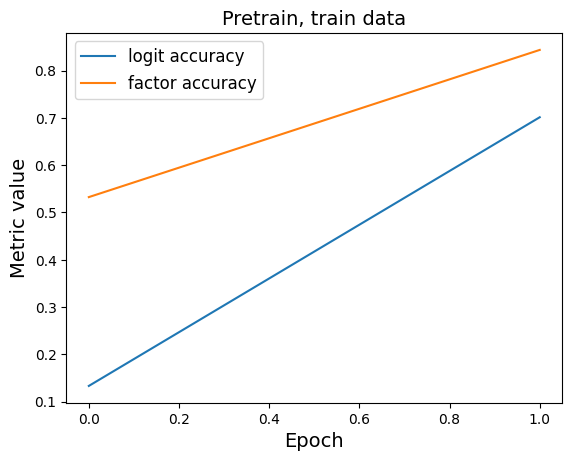

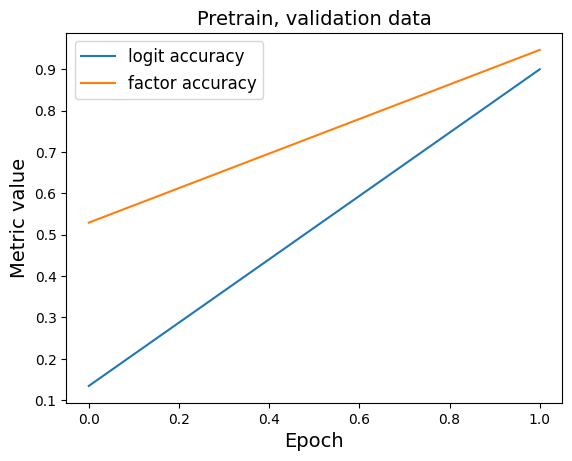

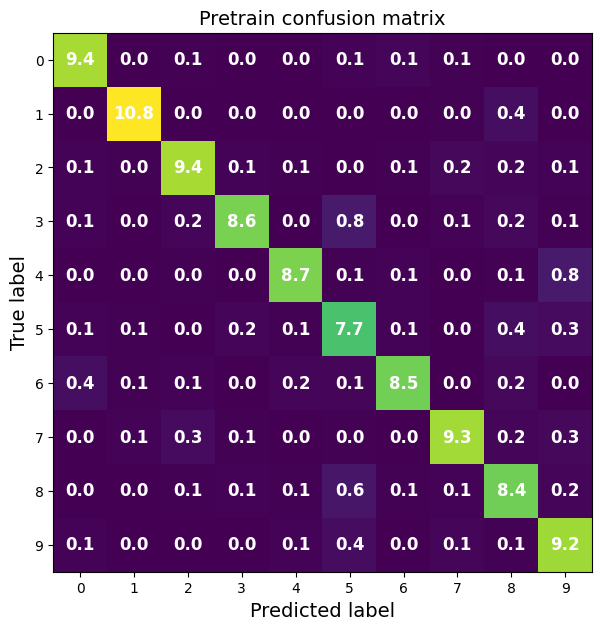

In [10]:
plot_pipeline_history(pretrain_metrics, title="Pretrain, train data", lognm="pertain_history_train_data")
plt.savefig(os.path.join(logpath, "pretrain_history_train_data.png"))
plt.show()
plot_pipeline_history(preval_metrics, title="Pretrain, validation data", lognm="pretrain_history_val_data")
plt.savefig(os.path.join(logpath, "pretrain_history_val_data.png"))
plt.show()

plot_conf_matrix(preval_metrics[-1]["logit"]["confusion"], "Pretrain confusion matrix")
plt.savefig(os.path.join(logpath, "pretrain_confusion_matrix_val_data.png"))
plt.show()

In [11]:
train_drifted_metrics = pipeline_eval_loop(pp, train_drifted_factored)
val_drifted_metrics = pipeline_eval_loop(pp, val_drifted_factored)
train_metrics, val_metrics = pipeline_train_loop(
    pp,
    train_drifted_factored,
    val_dataset=val_drifted_factored,
    optimizer=tf.keras.optimizers.Adam(),
    step=alg,
    epochs=train_epochs,
)
train_metrics = [train_drifted_metrics] + train_metrics
val_metrics = [val_drifted_metrics] + val_metrics

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

IntProgress(value=0, description='Epoch 0/1, 0.0s passed', layout=Layout(width='67%'), max=1, style=ProgressSt…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Epoch 1/1 train --', layout…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

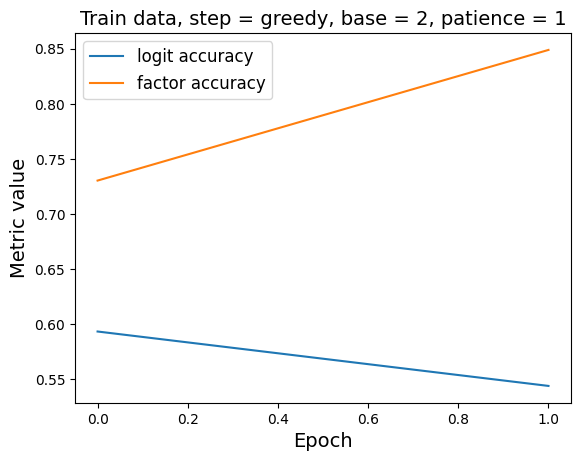

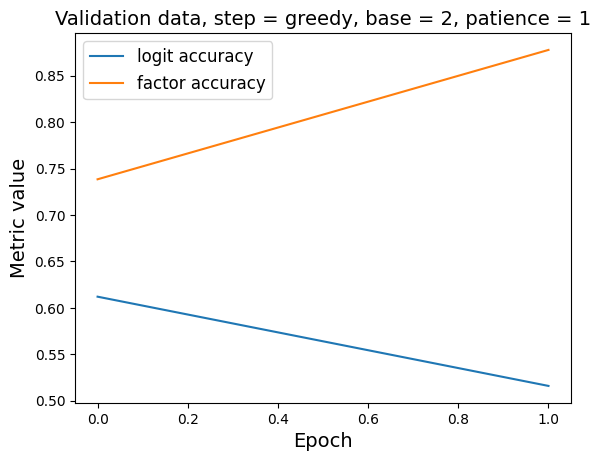

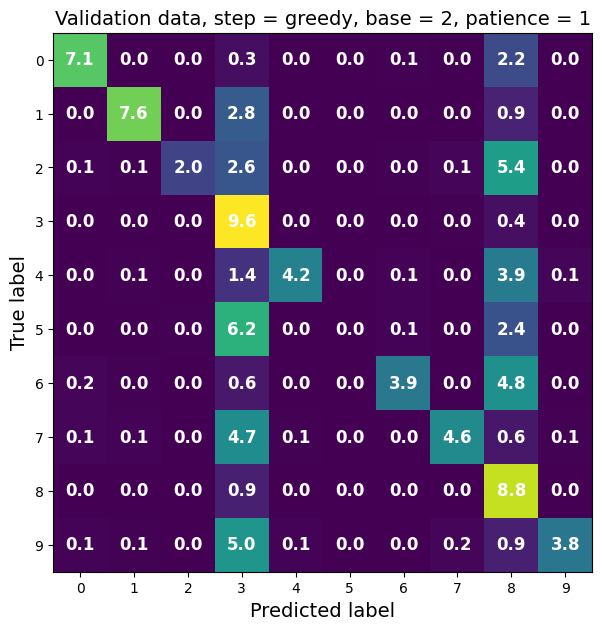

In [12]:
plot_pipeline_history(
    train_metrics,
    title=f"Train data, step = {alg}, base = {base}, patience = {patience}",
    lognm=f"{alg}_train_history_train_data",
)
plt.savefig(os.path.join(logpath, f"{alg}_train_history_train_data.png"))
plt.show()
plot_pipeline_history(
    val_metrics,
    title=f"Validation data, step = {alg}, base = {base}, patience = {patience}",
    lognm=f"{alg}_train_history_val_data",
)
plt.savefig(os.path.join(logpath, f"{alg}_train_history_val_data.png"))
plt.show()

plot_conf_matrix(
    val_metrics[-1]["logit"]["confusion"],
    f"Validation data, step = {alg}, base = {base}, patience = {patience}",
)
plt.savefig(os.path.join(logpath, f"{alg}_confusion_matrix_val_data.png"))
plt.show()


In [13]:
# train_virg_drifted_metrics = pipeline_eval_loop(pp_virg, train_drifted_factored)
train_virg_drifted_metrics = train_drifted_metrics
# val_virg_drifted_metrics = pipeline_eval_loop(pp_virg, val_drifted_factored)
val_virg_drifted_metrics = val_drifted_metrics
train_virg_metrics, val_virg_metrics = pipeline_train_loop(
    pp_virg,
    train_drifted_factored,
    val_dataset=val_drifted_factored,
    optimizer=tf.keras.optimizers.Adam(),
    step="cheet",
    epochs=train_epochs,
)
train_virg_metrics = [train_virg_drifted_metrics] + train_virg_metrics
val_virg_metrics = [val_virg_drifted_metrics] + val_virg_metrics

IntProgress(value=0, description='Epoch 0/1, 0.0s passed', layout=Layout(width='67%'), max=1, style=ProgressSt…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Epoch 1/1 train --', layout…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

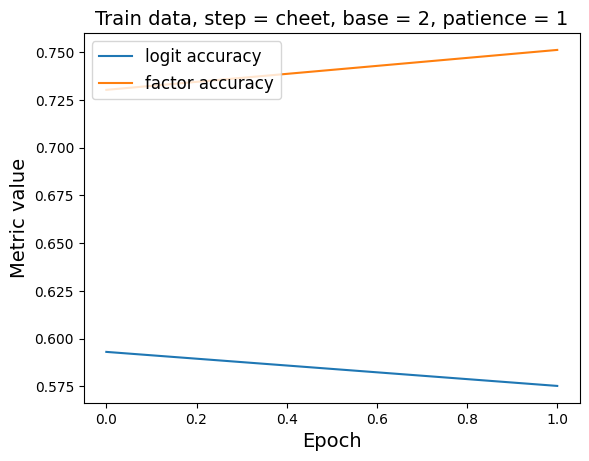

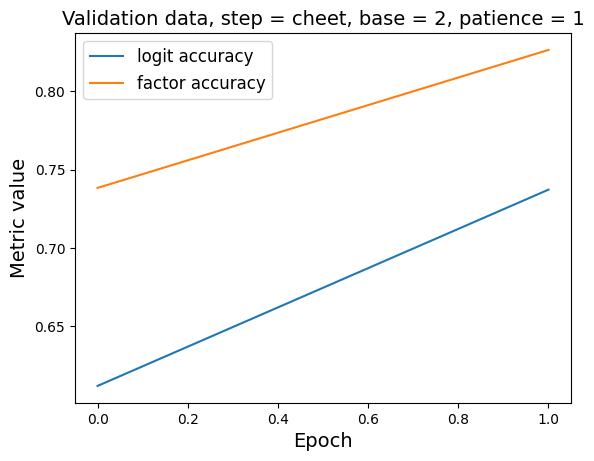

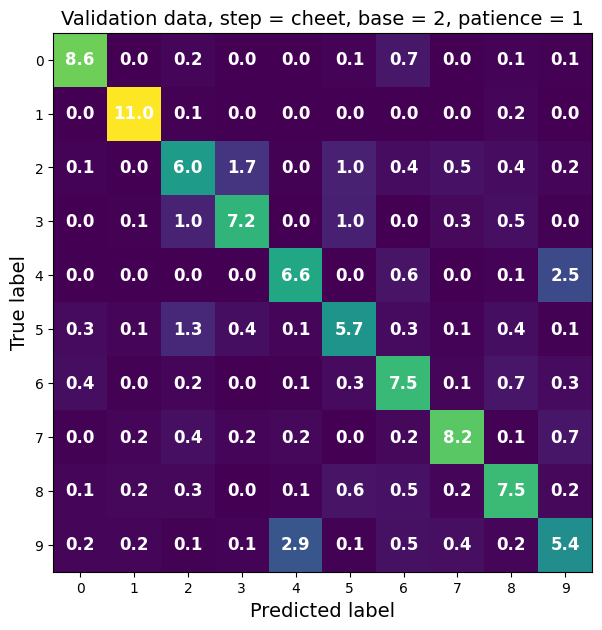

In [14]:
plot_pipeline_history(
    train_virg_metrics,
    title=f"Train data, step = cheet, base = {base}, patience = {patience}",
    lognm="cheet_train_history_train_data",
)
plt.savefig(os.path.join(logpath, "cheet_train_history_train_data.png"))
plt.show()
plot_pipeline_history(
    val_virg_metrics,
    title=f"Validation data, step = cheet, base = {base}, patience = {patience}",
    lognm="cheet_train_history_val_data",
)
plt.savefig(os.path.join(logpath, "cheet_train_history_val_data.png"))
plt.show()

plot_conf_matrix(
    val_virg_metrics[-1]["logit"]["confusion"],
    f"Validation data, step = cheet, base = {base}, patience = {patience}",
)
plt.savefig(os.path.join(logpath, f"cheet_confusion_matrix_val_data.png"))
plt.show()


In [15]:
posttrain_metrics = pipeline_eval_loop(pp, train_ref_factored)
postval_metrics = pipeline_eval_loop(pp, val_ref_factored)
posttrain_virg_metrics = pipeline_eval_loop(pp_virg, train_ref_factored)
postval_virg_metrics = pipeline_eval_loop(pp_virg, train_ref_factored)

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/79, 0.0s passed', layout=Layout(width='67%'), max=79, style=Progress…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

HTMLMath(value='\tlogit_accuracy: 0.0000;\tfactor_accuracy: 0.0000;', description='Validation --', layout=Layo…

IntProgress(value=0, description='Batch 0/469, 0.0s passed', layout=Layout(width='67%'), max=469, style=Progre…

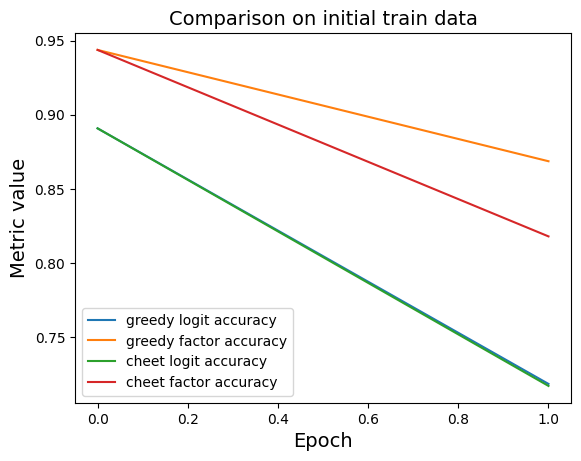

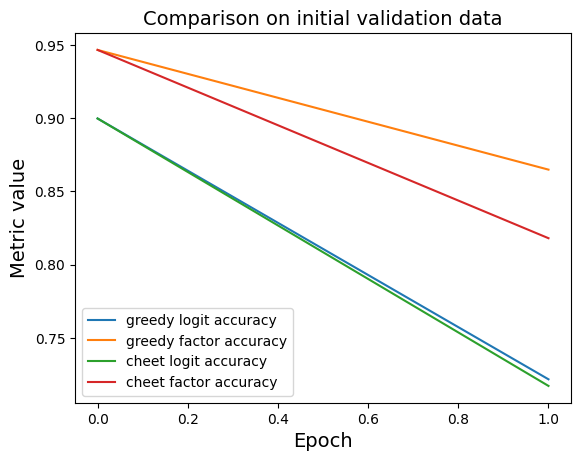

In [16]:
compare_train_metrics = [pretrain_final_metrics, posttrain_metrics]
compare_train_virg_metrics = [pretrain_final_metrics, posttrain_virg_metrics]
compare_val_metrics = [preval_final_metrics, postval_metrics]
compare_val_virg_metrics = [preval_final_metrics, postval_virg_metrics]
def prefix_metrics(metrics, prefix):
    return [
        {
            prefix + k: {
                m: M[k][m]
                for m in M[k]
            }
            for k in M}
        for M in metrics
    ]
compare_train_metrics = prefix_metrics(compare_train_metrics, f"{alg}_")
compare_train_virg_metrics = prefix_metrics(compare_train_virg_metrics, "cheet_")
compare_val_metrics = prefix_metrics(compare_val_metrics, f"{alg}_")
compare_val_virg_metrics = prefix_metrics(compare_val_virg_metrics, "cheet_")
# TODO add prefixes greedy_ and cheet_ to logit and factor
plot_pipeline_history(
    compare_train_metrics,
    lognm=f"{alg}_comparison_on_init_data_train_data",
)
plot_pipeline_history(
    compare_train_virg_metrics, title="Comparison on initial train data",
    lognm="cheet_comparison_on_init_data_train_data",
)
plt.legend(loc="lower left")
plt.savefig(os.path.join(logp, f"{alg}_n_cheet_comparison_on_init_data_train_data.png"))
plt.show()
plot_pipeline_history(
    compare_val_metrics,
    lognm=f"{alg}_comparison_on_init_data_val_data",
)
plot_pipeline_history(
    compare_val_virg_metrics, title="Comparison on initial validation data",
    lognm="cheet_comparison_on_init_data_val_data",
)
plt.legend(loc="lower left")
plt.savefig(os.path.join(logp, f"{alg}_n_cheet_comparison_on_init_data_val_data.png"))
plt.show()


In [18]:
logjs["finished"] = datetime.now().isoformat()
with open(os.path.join(logpath, "log.json"), "w") as logjsf:
    json.dump(logjs, logjsf, default=float)
ppr({"finished": logjs["finished"]})
# ppr(logjs)
ppr(f"log can be found at {os.path.join(logpath, 'log.json')}")


{'finished': '2024-10-12T13:00:07.701016'}
'log can be found at mnist_artifacts/pe1_te1_b2_p1_flip_greedy/log.json'
